In [5]:
import pybamm
import pybop
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt

In [6]:
# File path
path = r'C:\UM\Project\PulseTest\TVS_21700_HybridPulse_40Deg\trial_data'
file = 'One_pulse.csv'
file_path = os.path.join(path, file)

# Load CSV file directly
def load_data(file_path):
    data = pd.read_csv(file_path, skiprows=1).to_numpy()
    
    # Extract time, current, and voltage columns
    time = data[:, 0]  # Assuming first column is time
    current = data[:, 1]  # Assuming second column is current
    voltage = data[:, 2]  # Assuming third column is voltage
    initial_voltage = voltage[0]
    # Create PyBaMM interpolants
    current_interp = (-1*pybamm.Interpolant(time, current, pybamm.t))
    voltage_interp = pybamm.Interpolant(time, voltage, pybamm.t)
    
    initial_voltage = voltage[0]  # Set initial voltage
    return time, current, current_interp, voltage, voltage_interp, initial_voltage

In [7]:
def get_init_conc():
    time, current, current_interp, voltage, voltage_interp, initial_voltage = load_data(file_path)
    experiment = pybamm.Experiment(
    [
        f"Charge at 0.1 A until {initial_voltage} V",
        f"Hold at {initial_voltage} V until 0.1 mA"
    ]
    )
    model = pybamm.lithium_ion.SPMe()
    param = model.default_parameter_values
    param = pybamm.ParameterValues("Chen2020")
    sim_cccv = pybamm.Simulation(model, experiment=experiment, parameter_values=param)
    sol_cccv = sim_cccv.solve()
    #model.variables.search("Positive particle concentration")
    Negative_init_conc = sol_cccv["Average negative particle concentration [mol.m-3]"]
    Positive_init_conc = sol_cccv['Average positive particle concentration [mol.m-3]']
    return Negative_init_conc.data[-1], Positive_init_conc.data[-1]

a,b = get_init_conc()
print(a)
print(b)


2025-03-20 01:42:01.643 - [WARNING] simulation.solve(871): Step 'Charge at 0.1 A until 4.098 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.


27413.41172621561
20155.324873585934


In [8]:
# Define PyBaMM DFN model
def create_SPM_model(initial_voltage):
    model = pybamm.lithium_ion.SPMe()
    param = model.default_parameter_values
    param = pybamm.ParameterValues("Chen2020")
    # Estimate initial SOC
    c_n_init,c_p_init = get_init_conc()
    # Update parameters with initial concentrations
    param.update({
        "Initial concentration in negative electrode [mol.m-3]": c_n_init,
        "Initial concentration in positive electrode [mol.m-3]": c_p_init,
    })
    """
    experiment = pybamm.Experiment(
    [
        "Rest for 1 hour",
        "Discharge at C/30 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour",
    ])
    simu = pybamm.Simulation(model, experiment=experiment, parameter_values=param)
    simu.solve()
    simu.plot([
        "Voltage [V]",'Average positive particle concentration [mol.m-3]',])
    """
    return model, param
time, current, current_interp, voltage, voltage_interp, initial_voltage = load_data(file_path)
print(current_interp)
model, param = create_SPM_model(4.1)
param["Current function [A]"] = current_interp
sim = pybamm.Simulation(model, parameter_values=param)
sim.solve(time)
sim.plot([
        "Voltage [V]",'Average positive particle concentration [mol.m-3]','Current [A]',])

-ing_functio(time)


2025-03-20 01:42:03.791 - [WARNING] simulation.solve(871): Step 'Charge at 0.1 A until 4.098 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.


interactive(children=(FloatSlider(value=0.1, description='t', max=2899.8, min=0.1, step=28.998), Output()), _d…

In [9]:
iteration_counter = 0
def cost_function(params, time, current_interp, current, voltage_interp, voltage, model, param):
    # Update parameters (positive and negative electrode diffusivities)
    param["Current function [A]"] = current_interp
    param.update({
        "Negative electrode diffusivity [m2.s-1]": params[0],
        "Positive electrode diffusivity [m2.s-1]": params[1],
    })
    # Solve model with given parameters
    sim = pybamm.Simulation(model, parameter_values=param)
    sim.solve(time, inputs={"Current function [A]": current})

    # Extract simulated voltage
    sim_time = sim.solution["Time [s]"].entries
    sim_voltage = sim.solution["Terminal voltage [V]"].entries
    # Interpolate simulated voltage to match experimental time points
    interpolated_voltage = np.interp(time, sim_time, sim_voltage)

    # Compute error (RMSE)
    # scaled error
    scale = 100
    error = (np.sqrt(np.mean((interpolated_voltage - voltage) ** 2))) * scale
    global iteration_counter
    iteration_counter += 1
    print(f"Function evaluated {iteration_counter}: Parameters: {params}, RMSE: {error}")
    return error


In [10]:
# Optimization routine
def optimize_diffusivity_Nelder_Mead(file_path):
    time, current, current_interp, voltage, voltage_interp, initial_voltage = load_data(file_path)
    model, param = create_SPM_model(initial_voltage)
    
    # Initial guess for diffusivities
    initial_guess = [3.3e-14, 4e-15]  # from Chen2020
    
    # Run optimization
    result = minimize(cost_function, initial_guess, args=(time, current_interp, current, voltage_interp, voltage, model, param), 
                      method='Nelder-Mead', options={'maxiter': 500, 'maxfev': 1500, 'fatol': 1e-24, 'xatol': 1e-24, 'disp': True})
    #print(f"\n--- Results for fatol={result.fatol}, xtol={result.xatol} ---")
    optimized_diffusivities = result.x
    print(f"Optimization Status: {result.message}")
    print(f"Final RMSE Error: {result.fun}")
    print(f"Optimized Negative Electrode Diffusivity: {optimized_diffusivities[0]} m^2/s")
    print(f"Optimized Positive Electrode Diffusivity: {optimized_diffusivities[1]} m^2/s")

    # Store initial and optimized simulated voltage for comparison
    param_initial = param.copy()
    param_initial.update({
        "Negative electrode diffusivity [m2.s-1]": initial_guess[0],
        "Positive electrode diffusivity [m2.s-1]": initial_guess[1],
    })
    sim_initial = pybamm.Simulation(model, parameter_values=param_initial)
    sim_initial.solve(time, inputs={"Current function [A]": current})
    sim_voltage_initial = np.interp(time, sim_initial.solution["Time [s]"].entries, sim_initial.solution["Terminal voltage [V]"].entries)

    param_optimized = param.copy()
    param_optimized.update({
        "Negative electrode diffusivity [m2.s-1]": optimized_diffusivities[0],
        "Positive electrode diffusivity [m2.s-1]": optimized_diffusivities[1],
    })
    sim_optimized = pybamm.Simulation(model, parameter_values=param_optimized)
    sim_optimized.solve(time, inputs={"Current function [A]": current})
    sim_voltage_optimized = np.interp(time, sim_optimized.solution["Time [s]"].entries, sim_optimized.solution["Terminal voltage [V]"].entries)

    return time, voltage, sim_voltage_initial, sim_voltage_optimized, optimized_diffusivities


In [11]:
def optimize_diffusivity_trust_constr(file_path):
    time, current, current_interp, voltage, voltage_interp, initial_voltage = load_data(file_path)
    model, param = create_SPM_model(initial_voltage)
    
    # Initial guess for diffusivities
    initial_guess = [3.3e-14, 4e-15]  # from Chen2020
    
    # Define bounds for diffusivities (ensure physically realistic values)
    bounds = [(1e-18, 1e-9),  # Bounds for negative electrode diffusivity
              (1e-18, 1e-9)]  # Bounds for positive electrode diffusivity

    # Run optimization with bounds
   # Run optimization with 'trust-constr'
    result = minimize(
        cost_function, 
        initial_guess, 
        args=(time, current_interp, current, voltage_interp, voltage, model, param), 
        method='trust-constr', 
        bounds=bounds, 
        options={
            'maxiter': 500,   # More iterations for better convergence
            'gtol': 1e-18,     # Gradient tolerance (forces better stopping criteria)
            'xtol': 1e-18,     # Tolerance for parameter changes
            'disp': True       # Display optimization status
        }
    )
    
    optimized_diffusivities = result.x
    print(f"Optimization Status: {result.message}")
    print(f"Final RMSE Error: {result.fun}")
    print(f"Optimized Negative Electrode Diffusivity: {optimized_diffusivities[0]} m^2/s")
    print(f"Optimized Positive Electrode Diffusivity: {optimized_diffusivities[1]} m^2/s")

    # Store initial and optimized simulated voltage for comparison
    param_initial = param.copy()
    param_initial.update({
        "Negative electrode diffusivity [m2.s-1]": initial_guess[0],
        "Positive electrode diffusivity [m2.s-1]": initial_guess[1],
    })
    sim_initial = pybamm.Simulation(model, parameter_values=param_initial)
    sim_initial.solve(time, inputs={"Current function [A]": current})
    sim_voltage_initial = np.interp(time, sim_initial.solution["Time [s]"].entries, sim_initial.solution["Terminal voltage [V]"].entries)

    param_optimized = param.copy()
    param_optimized.update({
        "Negative electrode diffusivity [m2.s-1]": optimized_diffusivities[0],
        "Positive electrode diffusivity [m2.s-1]": optimized_diffusivities[1],
    })
    sim_optimized = pybamm.Simulation(model, parameter_values=param_optimized)
    sim_optimized.solve(time, inputs={"Current function [A]": current})
    sim_voltage_optimized = np.interp(time, sim_optimized.solution["Time [s]"].entries, sim_optimized.solution["Terminal voltage [V]"].entries)

    return time, voltage, sim_voltage_initial, sim_voltage_optimized, optimized_diffusivities

2025-03-20 01:42:10.586 - [WARNING] simulation.solve(871): Step 'Charge at 0.1 A until 4.098 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.


Function evaluated 1: Parameters: [3.3e-14 4.0e-15], RMSE: 0.6369760000647814
Function evaluated 2: Parameters: [3.465e-14 4.000e-15], RMSE: 0.6372962473764254
Function evaluated 3: Parameters: [3.3e-14 4.2e-15], RMSE: 0.6232085531511798
Function evaluated 4: Parameters: [3.135e-14 4.200e-15], RMSE: 0.6228905511696619
Function evaluated 5: Parameters: [2.97e-14 4.30e-15], RMSE: 0.616330812610283
Function evaluated 6: Parameters: [2.97e-14 4.50e-15], RMSE: 0.6049546177195074
Function evaluated 7: Parameters: [2.805e-14 4.750e-15], RMSE: 0.5921302043853149
Function evaluated 8: Parameters: [2.475e-14 4.850e-15], RMSE: 0.586701963369178
Function evaluated 9: Parameters: [2.0625e-14 5.1750e-15], RMSE: 0.5721449480302018
Function evaluated 10: Parameters: [1.8975e-14 5.6250e-15], RMSE: 0.5566443648077574
Function evaluated 11: Parameters: [1.36125e-14 6.28750e-15], RMSE: 0.5364940652768307
Function evaluated 12: Parameters: [6.1875e-15 6.7125e-15], RMSE: 0.5165349664047776
Function evaluate

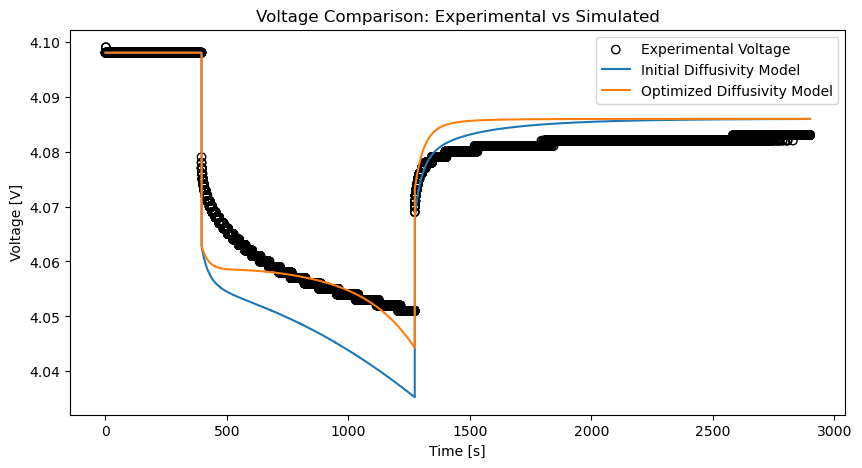

In [12]:
# Run optimization (Replace 'data.csv' with your actual CSV file)
if __name__ == "__main__":
    time, voltage, sim_voltage_initial, sim_voltage_optimized, optimized_diffusivities = optimize_diffusivity_Nelder_Mead(file_path)
    # Plot comparison at the end
    plt.figure(figsize=(10, 5))
    plt.scatter(time, voltage, label="Experimental Voltage", marker="o", facecolors='none', edgecolors='black')
    plt.plot(time, sim_voltage_initial, label="Initial Diffusivity Model")
    plt.plot(time, sim_voltage_optimized, label="Optimized Diffusivity Model")
    plt.xlabel("Time [s]")
    plt.ylabel("Voltage [V]")
    plt.legend()
    plt.title("Voltage Comparison: Experimental vs Simulated")
    plt.show()

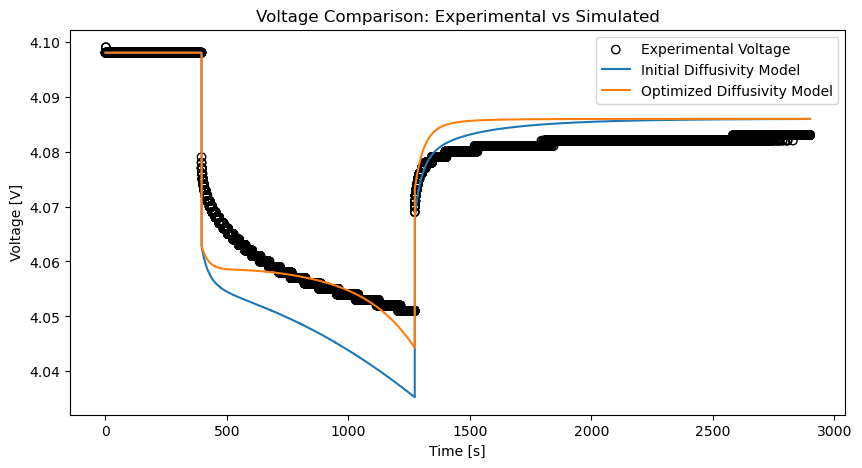

In [13]:
# Plot comparison at the end
plt.figure(figsize=(10, 5))
plt.scatter(time, voltage, label="Experimental Voltage", marker="o", facecolors='none', edgecolors='black')
plt.plot(time, sim_voltage_initial, label="Initial Diffusivity Model")
plt.plot(time, sim_voltage_optimized, label="Optimized Diffusivity Model")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.title("Voltage Comparison: Experimental vs Simulated")
plt.show()

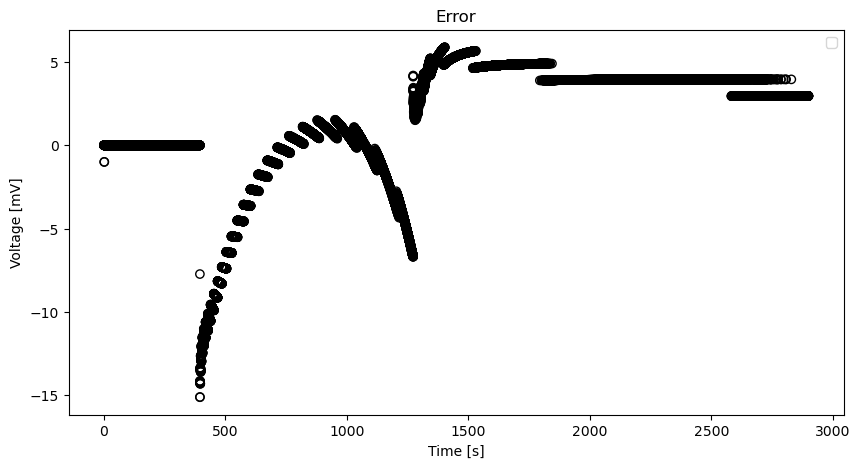

In [14]:
# Plot comparison at the end
plt.figure(figsize=(10, 5))
plt.scatter(time, 1000*(sim_voltage_optimized-voltage),  marker="o", facecolors='none', edgecolors='black')
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]")
plt.legend()
plt.title("Error")
plt.show()